## Dependencias

In [1]:
import numpy as np
import pandas as pd
import os
import json
from sqlalchemy.engine import create_engine

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from scikitplot.metrics import plot_roc

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


from scipy import stats
from varclushi import VarClusHi

from functools import reduce

import pickle
import asyncio
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
cf.go_offline()

In [2]:
def freq(df,var):
    if type(var)!=list:
        var = [var]
    for v in var:
        aux = df[v].value_counts().sort_index().to_frame().rename(columns={v:'FA'})
        aux['FR'] = aux['FA']/aux['FA'].sum()
        aux[['FAA','FRA']] = aux.apply(np.cumsum)
        print("Tabla de frecuencias para la variable **",v,"**","\n"*2)
        print(aux,"\n"*2)

In [3]:
dic=pd.read_excel('SIMAEC_NPS_Dic.xlsx')
nov=pd.read_excel('SIMAEC_NPS_Nov.xlsx')
oc= pd.read_excel('SIMAEC_NPS_Oct.xlsx')
sep=pd.read_excel('SIMAEC_NPS_Sep.xlsx')
ago=pd.read_excel('SIMAEC_NPS_Ago.xlsx')
jul=pd.read_excel('SIMAEC_NPS_Jul.xlsx')
jun=pd.read_excel('SIMAEC_NPS_Jun.xlsx')
may=pd.read_excel('SIMAEC_NPS_May.xlsx')
abr=pd.read_excel('SIMAEC_NPS_Abr.xlsx')
mar=pd.read_excel('SIMAEC_NPS_Mar.xlsx')
feb=pd.read_excel('SIMAEC_NPS_Feb.xlsx')
ene=pd.read_excel('SIMAEC_NPS_Ene.xlsx')

In [4]:
df=pd.concat([ene,feb,mar,abr,may,jun,jul,ago,sep,oc,nov,dic])

In [5]:
df.shape

(426630, 11)

In [6]:
a=[]
for file in os.listdir(r'C:\Users\VDMG015\Documents\Esteban\Tramites\Datos'):
        cdmx = pd.read_csv('Datos/'+file, dtype='str', usecols=['StartDate','telefonoUsuario','Q6'])
        cdmx = cdmx.iloc[2:].reset_index(drop=True)
        cdmx['StartDate']=pd.to_datetime(cdmx['StartDate'], format='%Y-%m-%d')
        cdmx['StartDate']=cdmx['StartDate'].dt.date
        cdmx = cdmx.rename(columns={'telefonoUsuario':'linea','StartDate':'fecha','Q6':'Solucion'})
        cdmx['fecha'] = cdmx['fecha'].astype(str)
        cdmx['Solucion'] = cdmx['Solucion'].replace({'Sí, y estoy satisfecho con el resultado.':'Sí', 'Sí, pero no estoy satisfecho con el resultado.':'Sí','No, mi requerimiento/trámite no se resolvió.':'No' })
        print(file)
        a.append(cdmx)
qx=pd.concat(a)

Encuesta CAC F_22 diciembre 2021_12.49.csv
Encuesta CAC F_23 diciembre 2021_17.34.csv
Encuesta CAC F_24 diciembre 2021_12.52.csv
Encuesta CAC F_24 diciembre 2021_13.00.csv


In [7]:
qx.drop_duplicates().shape, qx.shape

((875429, 3), (879918, 3))

In [8]:
qx=qx.drop_duplicates().reset_index(drop=True)

In [9]:
df['region']=df['region'].astype(str)

In [10]:
df['tramites']=df['tramites'].astype(str)

In [11]:
df['linea'] = df['linea'].astype(str)

In [12]:
df=df.merge(qx)

In [13]:
df=df[df['NPS_Asesor'].isin(['Detractor','Promotor'])].reset_index(drop=True)
df=df.dropna().reset_index(drop=True)

In [14]:
df=df.rename(columns={'tiempo_espera':'c_tiempo_espera','tiempo_tramite':'c_tiempo_tramite','tramites':'d_tramites','motivo':'d_motivo','cac':'d_cac','region':'d_region','Solucion':'d_Solucion'})

In [15]:
df['target']=(df['NPS_Asesor']=='Detractor').astype(int)

## Variables

In [16]:
um = ['linea','fecha']
varc = [v for v in df.columns if v[:2]=='c_']
vard = [v for v in df.columns if v[:2]=='d_']
vart =['target']
len(varc),len(vard)

(2, 5)

In [17]:
df=df.drop_duplicates(um).reset_index(drop=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367421 entries, 0 to 367420
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   linea             367421 non-null  object
 1   fecha             367421 non-null  object
 2   c_tiempo_espera   367421 non-null  int64 
 3   c_tiempo_tramite  367421 non-null  int64 
 4   d_tramites        367421 non-null  object
 5   d_motivo          367421 non-null  object
 6   d_cac             367421 non-null  object
 7   d_region          367421 non-null  object
 8   Asesor            367421 non-null  object
 9   NPS_Asesor        367421 non-null  object
 10  NPS_CAC           367421 non-null  object
 11  d_Solucion        367421 non-null  object
 12  target            367421 non-null  int32 
dtypes: int32(1), int64(2), object(10)
memory usage: 35.0+ MB


## Análisis Exploratorio

#### Varianza Nula

In [19]:
vt = VarianceThreshold()
vt.fit(df[varc])

VarianceThreshold()

In [20]:
df[varc]

,c_tiempo_espera,c_tiempo_tramite
0,19,352
1,75,816
2,64,476
3,46,798
4,24,530
...,...,...
367416,28,62
367417,30,1037
367418,572,394
367419,754,744


In [21]:
vt.transform(df[varc])

array([[ 19, 352],
       [ 75, 816],
       [ 64, 476],
       ...,
       [572, 394],
       [754, 744],
       [469, 755]], dtype=int64)

In [22]:
varc = [v for v,f in zip(varc,vt.get_support()) if f]
len(varc)

2

In [23]:
varc

['c_tiempo_espera', 'c_tiempo_tramite']

#### Discretización

In [24]:
def discretizar(k,metodo,variable):
    nm = df[um+[variable]].copy()

    kb = KBinsDiscretizer(n_bins=k,encode='ordinal',strategy=metodo)
    kb.fit(nm[[variable]])

    nm['d'] = kb.transform(nm[[variable]])
    mapa = dict(zip(range(k),['%02d. |%.1f---%.1f|'%(i+1,*s) for i,s in enumerate(list(zip(kb.bin_edges_[0],kb.bin_edges_[0][1:])))]))
    nm['d'].replace(mapa,inplace=True)
    nombre = f'd_{metodo[0]}_{k}_{variable}'
    nm = nm[um+['d']].rename(columns={'d':nombre})
    
    return nm

In [25]:
l=[]
for i in [(k,m,v) for k in range(2,10) for m in ['quantile','uniform', 'kmeans'] for v in varc]:
    a,b,c=i
    l.append(discretizar(a,b,c).iloc[:,2])

In [26]:
dfd=pd.concat(l,axis=1)

In [27]:
dfd[um]=df[um]

In [28]:
varcd = [v for v in dfd if v[:2]=='d_']

In [29]:
df=df.merge(dfd,on=um,how='inner')

In [30]:
df

,linea,fecha,c_tiempo_espera,c_tiempo_tramite,d_tramites,d_motivo,d_cac,d_region,Asesor,NPS_Asesor,NPS_CAC,d_Solucion,target,d_q_2_c_tiempo_espera,d_q_2_c_tiempo_tramite,d_u_2_c_tiempo_espera,d_u_2_c_tiempo_tramite,d_k_2_c_tiempo_espera,d_k_2_c_tiempo_tramite,d_q_3_c_tiempo_espera,d_q_3_c_tiempo_tramite,d_u_3_c_tiempo_espera,d_u_3_c_tiempo_tramite,d_k_3_c_tiempo_espera,d_k_3_c_tiempo_tramite,d_q_4_c_tiempo_espera,d_q_4_c_tiempo_tramite,d_u_4_c_tiempo_espera,d_u_4_c_tiempo_tramite,d_k_4_c_tiempo_espera,d_k_4_c_tiempo_tramite,d_q_5_c_tiempo_espera,d_q_5_c_tiempo_tramite,d_u_5_c_tiempo_espera,d_u_5_c_tiempo_tramite,d_k_5_c_tiempo_espera,d_k_5_c_tiempo_tramite,d_q_6_c_tiempo_espera,d_q_6_c_tiempo_tramite,d_u_6_c_tiempo_espera,d_u_6_c_tiempo_tramite,d_k_6_c_tiempo_espera,d_k_6_c_tiempo_tramite,d_q_7_c_tiempo_espera,d_q_7_c_tiempo_tramite,d_u_7_c_tiempo_espera,d_u_7_c_tiempo_tramite,d_k_7_c_tiempo_espera,d_k_7_c_tiempo_tramite,d_q_8_c_tiempo_espera,d_q_8_c_tiempo_tramite,d_u_8_c_tiempo_espera,d_u_8_c_tiempo_tramite,d_k_8_c_tiempo_espera,d_k_8_c_tiempo_tramite,d_q_9_c_tiempo_espera,d_q_9_c_tiempo_tramite,d_u_9_c_tiempo_espera,d_u_9_c_tiempo_tramite,d_k_9_c_tiempo_espera,d_k_9_c_tiempo_tramite
0,2211011053,2021-01-07,19,352,1,A PORTABILIDAD,PUEBLA V,7,PAC3AD8,Promotor,Promotor,Sí,0,01. |0.0---50.0|,01. |0.0---1211.0|,01. |0.0---6704.5|,01. |0.0---21753.5|,01. |0.0---904.8|,01. |0.0---2524.9|,01. |0.0---34.0|,01. |0.0---805.0|,01. |0.0---4469.7|,01. |0.0---14502.3|,01. |0.0---528.0|,01. |0.0---1742.3|,01. |0.0---30.0|,01. |0.0---641.0|,01. |0.0---3352.2|,01. |0.0---10876.8|,01. |0.0---394.9|,01. |0.0---1739.8|,01. |0.0---28.0|,01. |0.0---548.0|,01. |0.0---2681.8|,01. |0.0---8701.4|,01. |0.0---312.9|,01. |0.0---1359.5|,01. |0.0---26.0|,01. |0.0---486.0|,01. |0.0---2234.8|,01. |0.0---7251.2|,01. |0.0---262.2|,01. |0.0---1130.5|,01. |0.0---25.0|,01. |0.0---442.0|,01. |0.0---1915.6|,01. |0.0---6215.3|,01. |0.0---229.4|,01. |0.0---961.5|,01. |0.0---24.0|,01. |0.0---408.0|,01. |0.0---1676.1|,01. |0.0---5438.4|,01. |0.0---203.3|,01. |0.0---845.7|,01. |0.0---23.0|,01. |0.0---381.0|,01. |0.0---1489.9|,01. |0.0---4834.1|,01. |0.0---179.9|,01. |0.0---769.5|
1,2211020306,2021-01-22,75,816,1,A INFORMES DE PORTABILIDAD,PUEBLA ZOCALO,7,PACD35A,Promotor,Promotor,Sí,0,02. |50.0---13409.0|,01. |0.0---1211.0|,01. |0.0---6704.5|,01. |0.0---21753.5|,01. |0.0---904.8|,01. |0.0---2524.9|,02. |34.0---219.0|,02. |805.0---1826.0|,01. |0.0---4469.7|,01. |0.0---14502.3|,01. |0.0---528.0|,01. |0.0---1742.3|,03. |50.0---406.0|,02. |641.0---1211.0|,01. |0.0---3352.2|,01. |0.0---10876.8|,01. |0.0---394.9|,01. |0.0---1739.8|,03. |38.0---111.0|,02. |548.0---951.0|,01. |0.0---2681.8|,01. |0.0---8701.4|,01. |0.0---312.9|,01. |0.0---1359.5|,04. |50.0---219.0|,03. |805.0---1211.0|,01. |0.0---2234.8|,01. |0.0---7251.2|,01. |0.0---262.2|,01. |0.0---1130.5|,04. |41.0---81.0|,03. |709.0---1019.0|,01. |0.0---1915.6|,01. |0.0---6215.3|,01. |0.0---229.4|,01. |0.0---961.5|,05. |50.0---147.0|,03. |641.0---895.0|,01. |0.0---1676.1|,01. |0.0---5438.4|,01. |0.0---203.3|,01. |0.0---845.7|,06. |70.0---219.0|,04. |805.0---1060.0|,01. |0.0---1489.9|,01. |0.0---4834.1|,01. |0.0---179.9|,02. |769.5---1454.2|
2,2211030413,2021-01-26,64,476,1,A POR ACTUALIZACION VERSION,PUE II SAN ANGEL,7,PACF9E1,Promotor,Promotor,Sí,0,02. |50.0---13409.0|,01. |0.0---1211.0|,01. |0.0---6704.5|,01. |0.0---21753.5|,01. |0.0---904.8|,01. |0.0---2524.9|,02. |34.0---219.0|,01. |0.0---805.0|,01. |0.0---4469.7|,01. |0.0---14502.3|,01. |0.0---528.0|,01. |0.0---1742.3|,03. |50.0---406.0|,01. |0.0---641.0|,01. |0.0---3352.2|,01. |0.0---10876.8|,01. |0.0---394.9|,01. |0.0---1739.8|,03. |38.0---111.0|,01. |0.0---548.0|,01. |0.0---2681.8|,01. |0.0---8701.4|,01. |0.0---312.9|,01. |0.0---1359.5|,04. |50.0---219.0|,01. |0.0---486.0|,01. |0.0---2234.8|,01. |0.0---7251.2|,01. |0.0---262.2|,01. |0.0---1130.5|,04. |41.0---81.0|,02. |442.0---709.0|,01. |0.0---1915.6|,01. |0.0---6215.3|,01. |0.0---229.4|,01. |0.0---961.5|,05. |50.

### Discreto

#### Normalización

In [31]:
def normalizar(df,v,umbral=0.03):
    aux = df[v].value_counts(True).to_frame()
    aux[f'norm_{v}'] = np.where(aux[v]<umbral,'PEQUEÑAS CATEGORÍAS',aux.index)
    moda = aux.head(1)[f'norm_{v}'].values[0]
    if aux.loc[aux[f'norm_{v}']=='PEQUEÑAS CATEGORÍAS'][v].sum()<umbral:
        aux[f'norm_{v}'].replace({'PEQUEÑAS CATEGORÍAS':moda},inplace=True)
    aux.drop(v,axis=1,inplace=True)
    aux.reset_index(inplace=True)
    return v,aux[aux['index']!=aux[f'norm_{v}']].set_index('index').to_dict()[f'norm_{v}']

In [32]:
df['n_d_cac']=df['d_cac'].replace(normalizar(df,'d_cac',0.005)[1])
df['n_d_motivo']=df['d_motivo'].replace(normalizar(df,'d_motivo',0.005)[1])

In [33]:
df['n_d_region']=df['d_region'].copy()
df['n_d_Solucion']=df['d_Solucion'].copy()

In [37]:
varn = [v for v in df.columns if v[:2]=='n_']

In [38]:
freq(df,varn)

Tabla de frecuencias para la variable ** n_d_cac ** 


                          FA        FR     FAA       FRA
BUENAVISTA              3110  0.008464    3110  0.008464
CUICUILCO               2084  0.005672    5194  0.014136
GALERIAS COAPA          1915  0.005212    7109  0.019348
GALERIAS PACHUCA        2552  0.006946    9661  0.026294
GALERIAS TOLUCA         1881  0.005119   11542  0.031414
IXTAPALUCA              2664  0.007251   14206  0.038664
LAS AMERICAS            3980  0.010832   18186  0.049496
LAZARO CARDENAS         2184  0.005944   20370  0.055440
NEZA                    2443  0.006649   22813  0.062090
PABELLON DEL VALLE      2704  0.007359   25517  0.069449
PARQUE DELTA            2844  0.007740   28361  0.077189
PARQUE LINDAVISTA       3757  0.010225   32118  0.087415
PARQUE TEZONTLE         2701  0.007351   34819  0.094766
PASEO ACOXPA            2245  0.006110   37064  0.100876
PEQUEÑAS CATEGORÍAS   311092  0.846691  348156  0.947567
PLAZA CARSO             1867  0.0

### Unarias

In [39]:
unarias = [v for v,n in map(lambda v:(v,df[v].nunique()),varn+varcd) if n ==1]
df.drop(unarias,axis=1,inplace=True)
varn = [v for v in varn if v not in unarias]
varcd = [v for v in varcd if v not in unarias]

In [40]:
varcd

['d_q_2_c_tiempo_espera',
 'd_q_2_c_tiempo_tramite',
 'd_u_2_c_tiempo_espera',
 'd_u_2_c_tiempo_tramite',
 'd_k_2_c_tiempo_espera',
 'd_k_2_c_tiempo_tramite',
 'd_q_3_c_tiempo_espera',
 'd_q_3_c_tiempo_tramite',
 'd_u_3_c_tiempo_espera',
 'd_u_3_c_tiempo_tramite',
 'd_k_3_c_tiempo_espera',
 'd_k_3_c_tiempo_tramite',
 'd_q_4_c_tiempo_espera',
 'd_q_4_c_tiempo_tramite',
 'd_u_4_c_tiempo_espera',
 'd_u_4_c_tiempo_tramite',
 'd_k_4_c_tiempo_espera',
 'd_k_4_c_tiempo_tramite',
 'd_q_5_c_tiempo_espera',
 'd_q_5_c_tiempo_tramite',
 'd_u_5_c_tiempo_espera',
 'd_u_5_c_tiempo_tramite',
 'd_k_5_c_tiempo_espera',
 'd_k_5_c_tiempo_tramite',
 'd_q_6_c_tiempo_espera',
 'd_q_6_c_tiempo_tramite',
 'd_u_6_c_tiempo_espera',
 'd_u_6_c_tiempo_tramite',
 'd_k_6_c_tiempo_espera',
 'd_k_6_c_tiempo_tramite',
 'd_q_7_c_tiempo_espera',
 'd_q_7_c_tiempo_tramite',
 'd_u_7_c_tiempo_espera',
 'd_u_7_c_tiempo_tramite',
 'd_k_7_c_tiempo_espera',
 'd_k_7_c_tiempo_tramite',
 'd_q_8_c_tiempo_espera',
 'd_q_8_c_tiempo_tra

## Análisis bi-variado

In [41]:
def calcularIV(df,v,tgt):
    aux = df[[v]+tgt].copy().assign(n=1)
    aux = aux.pivot_table(index=v,columns=tgt,values='n',aggfunc='sum',fill_value=0)
    aux/=aux.sum()
    aux['w'] = np.log(aux[0]/aux[1])
    aux['iv'] = (aux[0]-aux[1])*aux['w']
    return v,aux['iv'].sum()

In [42]:
ivreport = pd.DataFrame(map(lambda v:calcularIV(df,v,vart),varn+varcd),columns=['var','iv'])

In [43]:
ivreport = ivreport.loc[(ivreport['iv']>=0.01)&(~np.isinf(ivreport['iv']))].reset_index(drop=True)

In [44]:
ivreport['raíz'] = ivreport['var'].map(lambda x:x if x[:2]=='n_' else "_".join(x.split('_')[3:]))

In [45]:
ivreport.sort_values

,var,iv,raíz
0,n_d_cac,0.017279,n_d_cac
1,n_d_motivo,0.305313,n_d_motivo
2,n_d_region,0.018200,n_d_region
3,n_d_Solucion,2.453404,n_d_Solucion
4,d_q_2_c_tiempo_espera,0.010127,c_tiempo_espera
5,d_q_2_c_tiempo_tramite,0.024639,c_tiempo_tramite
6,d_k_2_c_tiempo_espera,0.016580,c_tiempo_espera
7,d_k_2_c_tiempo_tramite,0.041724,c_tiempo_tramite
8,d_q_3_c_tiempo_espera,0.017254,c_tiempo_espera
9,d_q_3_c_tiempo_tramite,0.042655,c_tiempo_tramite


In [46]:
best = list(ivreport.sort_values(by=['raíz','iv'],ascending=[1,0]).groupby('raíz').first()['var'])

In [47]:
best

['d_q_9_c_tiempo_espera',
 'd_q_9_c_tiempo_tramite',
 'n_d_Solucion',
 'n_d_cac',
 'n_d_motivo',
 'n_d_region']

## Partición

In [146]:
test = df.loc[pd.to_datetime(df['fecha'])>=pd.to_datetime('2021-11-1')].reset_index(drop=True).copy()[um+best+vart]

In [147]:
train,val = train_test_split(df.loc[pd.to_datetime(df['fecha'])<pd.to_datetime('2021-11-1')].reset_index(drop=True).copy()[um+best+vart],train_size=0.7)
train.reset_index(drop=True,inplace=True)
val.reset_index(drop=True,inplace=True)

In [148]:
train.head()

,linea,fecha,d_q_5_c_tiempo_espera,d_q_5_c_tiempo_tramite,n_d_Solucion,n_d_cac,n_d_motivo,n_d_region,n_d_tramites,target
0,9611750191,2021-01-07,05. |553.0---13409.0|,02. |548.0---951.0|,Sí,PEQUEÑAS CATEGORÍAS,PEQUEÑAS CATEGORÍAS,8,1,0
1,5541350422,2021-07-27,02. |28.0---38.0|,01. |0.0---548.0|,Sí,PEQUEÑAS CATEGORÍAS,T INFORMES DE TARIFA DE VOZ Y DATOS,9,1,0
2,9982417388,2021-07-28,02. |28.0---38.0|,04. |1542.0---2596.0|,No,PEQUEÑAS CATEGORÍAS,T POR CIRCULO AZUL,8,1,1
3,3111590040,2021-04-01,03. |38.0---111.0|,04. |1542.0---2596.0|,Sí,PEQUEÑAS CATEGORÍAS,PEQUEÑAS CATEGORÍAS,5,2,0
4,9982121126,2021-03-17,03. |38.0---111.0|,05. |2596.0---43507.0|,Sí,PEQUEÑAS CATEGORÍAS,T CAMBIO DE IMEI CON REACTIVACION,8,2,0


In [149]:
train.shape,val.shape,test.shape

((214655, 10), (91995, 10), (60771, 10))

## WoE

In [150]:
def calcularWoE(df,v,tgt):
    aux = df[[v]+tgt].copy().assign(n=1)
    aux = aux.pivot_table(index=v,columns=tgt,values='n',aggfunc='sum',fill_value=0)
    aux/=aux.sum()
    aux['w'] = np.log(aux[0]/aux[1])
    return v,aux['w'].to_dict()

In [151]:
for v,mapa in map(lambda v:calcularWoE(train,v,vart),best):
    train[f'w_{v}'] = train[v].replace(mapa)
    val[f'w_{v}'] = val[v].replace(mapa)
    test[f'w_{v}'] = test[v].replace(mapa)

In [152]:
varw = [v for v in train.columns if v[:2]=='w_']

In [153]:
train[varw].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214655 entries, 0 to 214654
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   w_d_q_5_c_tiempo_espera   214655 non-null  float64
 1   w_d_q_5_c_tiempo_tramite  214655 non-null  float64
 2   w_n_d_Solucion            214655 non-null  float64
 3   w_n_d_cac                 214655 non-null  float64
 4   w_n_d_motivo              214655 non-null  float64
 5   w_n_d_region              214655 non-null  float64
 6   w_n_d_tramites            214655 non-null  float64
dtypes: float64(7)
memory usage: 11.5 MB


## Entrenamiento del modelo

In [154]:
lr = LogisticRegression()

In [155]:
lr.fit(train[varw],train[vart])

LogisticRegression()

In [156]:
train['proba'] = lr.predict_proba(train[varw])[:,1]
val['proba']= lr.predict_proba(val[varw])[:,1]
test['proba']= lr.predict_proba(test[varw])[:,1]

In [157]:
print(roc_auc_score(y_score=train['proba'],y_true=train[vart]))
print(roc_auc_score(y_score=val['proba'],y_true=val[vart]))
print(roc_auc_score(y_score=test['proba'],y_true=test[vart]))

0.8529639068714315
0.8532749693287827
0.8684404842473695


In [158]:
from scikitplot.metrics import plot_ks_statistic,plot_roc_curve

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

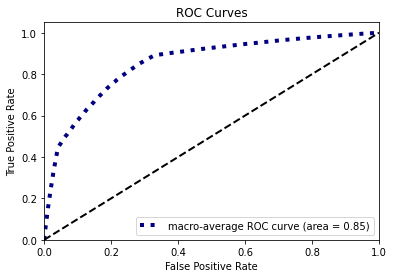

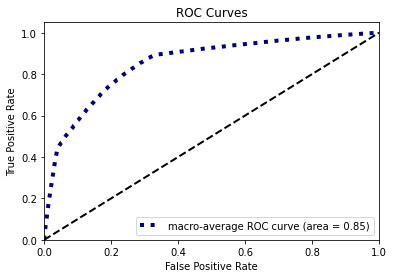

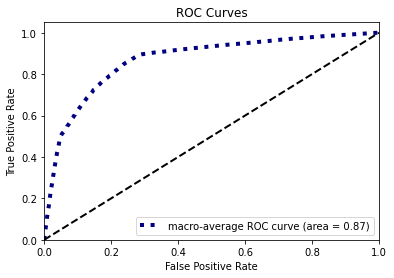

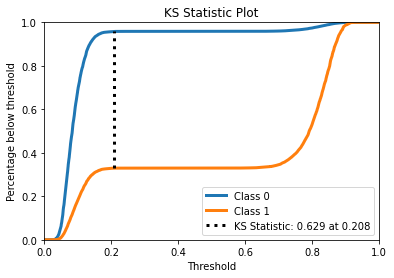

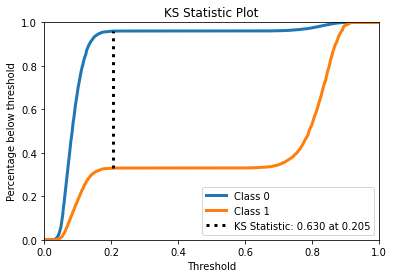

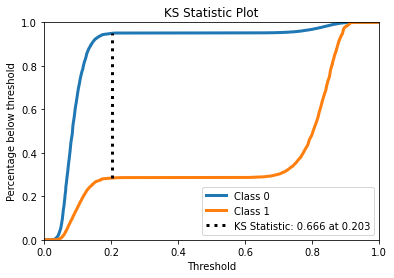

In [161]:
plot_roc_curve(y_probas=lr.predict_proba(train[varw]),y_true=train[vart[0]],curves='macro')
plot_roc_curve(y_probas=lr.predict_proba(val[varw]),y_true=val[vart[0]],curves='macro')
plot_roc_curve(y_probas=lr.predict_proba(test[varw]),y_true=test[vart[0]],curves='macro')

plot_ks_statistic(y_probas=lr.predict_proba(train[varw]),y_true=train[vart[0]])
plot_ks_statistic(y_probas=lr.predict_proba(val[varw]),y_true=val[vart[0]])
plot_ks_statistic(y_probas=lr.predict_proba(test[varw]),y_true=test[vart[0]])

In [ ]:
score_base = 400
pdo = 52

## Scoring

In [276]:
score_base = 400
momios_base = 1
pdo = 52
factor = pdo/np.log(2)
offset = score_base-factor*np.log(momios_base)
n = len(varw)
factor,offset,n


(76.46283716711507, 400.0, 7)

In [277]:
betas,alpha = list(lr.coef_[0]),lr.intercept_[0]
betas,alpha

([-0.9312133208814352,
  -0.7626987846744326,
  -0.9623692368549573,
  -0.609394415114643,
  -0.47961982722339386,
  -0.7033884849341085,
  -0.01050842106734897],
 -1.2636093176314185)

In [278]:
for beta,v in zip(betas,varw):
    train[f'P_{v}'] = np.round((-train[v]*beta+alpha/n)*factor+offset/n,0)
    val[f'P_{v}'] = np.round((-val[v]*beta+alpha/n)*factor+offset/n,0)
    test[f'P_{v}'] = np.round((-test[v]*beta+alpha/n)*factor+offset/n,0)

In [279]:
train['score'] = train.filter(like='P_').sum(axis=1)
val['score'] = val.filter(like='P_').sum(axis=1)
test['score'] = test.filter(like='P_').sum(axis=1)

In [280]:
aux = test['score'].describe().to_frame().T
aux['max'],aux['min'],aux['max']-aux['min']

(score    509.0
 Name: max, dtype: float64,
 score    11.0
 Name: min, dtype: float64,
 score    498.0
 dtype: float64)

<AxesSubplot:xlabel='score', ylabel='Density'>

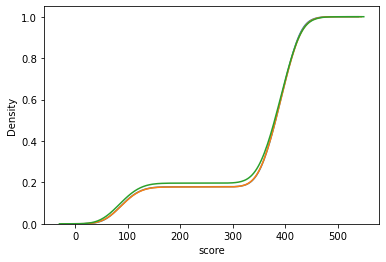

In [281]:
sns.kdeplot(data=train,x='score',cumulative=True)
sns.kdeplot(data=val,x='score',cumulative=True)
sns.kdeplot(data=test,x='score',cumulative=True)

In [282]:
len(range(10,460,50))

9

In [284]:
10-573

-563

In [289]:
568/63

9.015873015873016

In [290]:
train['r_score'] = pd.cut(train['score'],bins=range(10,578,63),include_lowest=True).astype(str)
val['r_score'] = pd.cut(val['score'],bins=range(10,578,63),include_lowest=True).astype(str)
test['r_score'] = pd.cut(test['score'],bins=range(10,578,63),include_lowest=True).astype(str)

In [291]:
train[['d_q_5_c_tiempo_espera','P_w_d_q_5_c_tiempo_espera']].drop_duplicates()

,d_q_5_c_tiempo_espera,P_w_d_q_5_c_tiempo_espera
0,05. |553.0---13409.0|,27.0
1,02. |28.0---38.0|,47.0
3,03. |38.0---111.0|,50.0
5,04. |111.0---553.0|,40.0
7,01. |0.0---28.0|,54.0


### Scorecard

In [292]:
varp = [v for v in train.columns if v[:2]=='P_']
sc = []
for v in varp:
    nombre = "_".join(v.split('_')[2:])
    nombre = "_".join(nombre.split('_')[2:]) if nombre[:2]=='n_' else "_".join(nombre.split('_')[4:])
    aux = train[[v,v[4:]]].drop_duplicates().reset_index(drop=True).assign(caracteristica=nombre)
    aux.columns = ['puntos','atributo','caracteristica']
    sc.append(aux)
aux = pd.concat(sc,ignore_index=True)
sc = aux.groupby(['caracteristica','atributo']).min()
sc

puntos
caracteristica atributo                      
Solucion       No                      -161.0
               Sí                       122.0
cac            BUENAVISTA                26.0
               CUICUILCO                 33.0
               GALERIAS COAPA            30.0
...                                       ...
tiempo_tramite 05. |2596.0---43507.0|    68.0
tramites       1                         43.0
               2                         44.0
               3                         44.0
               4                         44.0

[95 rows x 1 columns]

In [293]:
sc.to_clipboard()

## Reportes

In [294]:
aux = pd.concat([train.merge(df[um],on=um,how='inner')[um+vart+['r_score']].assign(muestra='ent'),\
val.merge(df[um],on=um,how='inner')[um+vart+['r_score']].assign(muestra='val'),\
test.merge(df[um],on=um,how='inner')[um+vart+['r_score']].assign(muestra='test')],ignore_index=True)

In [295]:
aux

,linea,fecha,target,r_score,muestra
0,9611750191,2021-01-07,0,"(325.0, 388.0]",ent
1,5541350422,2021-07-27,0,"(325.0, 388.0]",ent
2,9982417388,2021-07-28,1,"(73.0, 136.0]",ent
3,3111590040,2021-04-01,0,"(388.0, 451.0]",ent
4,9982121126,2021-03-17,0,"(388.0, 451.0]",ent
...,...,...,...,...,...
367416,9999966195,2021-12-17,0,"(325.0, 388.0]",test
367417,9999974393,2021-12-11,1,"(73.0, 136.0]",test
367418,9999975058,2021-12-08,1,"(73.0, 136.0]",test
367419,9999981332,2021-12-20,1,"(9.999, 73.0]",test


In [296]:
aux['fecha'] = pd.to_datetime(aux['fecha']).map(lambda x:x.strftime('%Y%m'))

In [297]:
aux.groupby(['fecha','r_score','muestra','target']).count().to_clipboard()

In [298]:
df['target'].value_counts(1)

0    0.781033
1    0.218967
Name: target, dtype: float64

In [299]:
aux['r_score'].value_counts()

(388.0, 451.0]    155810
(325.0, 388.0]    139151
(73.0, 136.0]      43940
(9.999, 73.0]      19850
(451.0, 514.0]      3633
(136.0, 199.0]      2815
(262.0, 325.0]      2218
(199.0, 262.0]         4
Name: r_score, dtype: int64